# Práctica: Fusión, Transformaciones, Feature Engineering y Clustering


## 0) Carga de datos

Imports, carga de datos desde Drive y visualización de los archivos del zip de Datos

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from matplotlib.patches import Patch

In [ ]:
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Master/TID/Datos-20251113.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Archivos extraídos a: {extract_path}")
!ls {extract_path}

In [3]:
DATAFRAMES = {}
archivos = ['diagnosis.csv', 'edstays.csv', 'medrecon.csv', 'pyxis.csv', 'triage.csv', 'vitalsign.csv']

for archivo in archivos:
    try:
        df_name = archivo.replace('.csv', '')
        DATAFRAMES[df_name] = pd.read_csv(f'/content/{archivo}')
        print(f"Cargado: {archivo} - Dimensiones: {DATAFRAMES[df_name].shape}")
    except Exception as e:
        print(f"Error cargando {archivo}: {e}")

print(f"\nTotal de datasets cargados: {len(DATAFRAMES)}")
print(f"Datasets disponibles: {list(DATAFRAMES.keys())}")

Cargado: diagnosis.csv - Dimensiones: (545, 6)
Cargado: edstays.csv - Dimensiones: (222, 9)
Cargado: medrecon.csv - Dimensiones: (2764, 9)
Cargado: pyxis.csv - Dimensiones: (1082, 7)
Cargado: triage.csv - Dimensiones: (222, 11)
Cargado: vitalsign.csv - Dimensiones: (1038, 11)

Total de datasets cargados: 6
Datasets disponibles: ['diagnosis', 'edstays', 'medrecon', 'pyxis', 'triage', 'vitalsign']


## 1) Agrupar diagnósticos por estancia

***TODO:** implementa la agrupación para generar `df_diag_grouped` con columnas `stay_id` y `icd_codes`.*

**Explicación:**

Hemos realizado la agrupación de diagnósticos para consolidar toda la información de cada paciente en una única fila. Partiendo de la tabla de diagnósticos que contenía múltiples registros por paciente, hemos agrupado por el identificador de estancia (stay_id) y creado dos nuevas variables:

- icd_codes: lista con todos los códigos de diagnóstico de cada paciente
- num_diagnoses: conteo del número total de diagnósticos por paciente



In [4]:
print("AGRUPACIÓN DE DIAGNÓSTICOS POR ESTANCIA")

df_diagnosis = DATAFRAMES['diagnosis']

# Agrupacion de todos los códigos ICD por stay_id
df_diag_grouped = df_diagnosis.groupby('stay_id')['icd_code'].agg(
    icd_codes=lambda x: list(x),
    num_diagnoses=lambda x: len(x)
).reset_index()

print(f"Dimensiones de df_diag_grouped: {df_diag_grouped.shape}")
print(f"Primeras 3 filas:")
print(df_diag_grouped.head(3))
print(f"\nNúmero de stay_ids: {df_diag_grouped['stay_id'].nunique()}")

AGRUPACIÓN DE DIAGNÓSTICOS POR ESTANCIA
Dimensiones de df_diag_grouped: (221, 3)
Primeras 3 filas:
    stay_id                            icd_codes  num_diagnoses
0  30094124                         [E860, R531]              2
1  30115213  [F10129, S066X9A, S12600A, V4352XA]              4
2  30193781                [F28, D72829, F10239]              3

Número único de stay_ids: 221


**Resultados obtenidos:**

- Hay 221 pacientes con diagnósticos registrados
- El número promedio de diagnósticos por paciente es de 2.47 (545 diagnosticos / 221 pacientes)

## 2) Agrupar triage y vitals

***TODO:** agrupa `triage` y `vitalsign` de forma robusta (solo usar columnas existentes).*

**Explicacion:**

Ahora agrupamos los datos de triage y vitalsign para crear una visión unificada del estado clínico de cada paciente. Para eso:

- Partimos de dos datasets: triage (222 pacientes, 11 variables) y vitalsign (1038 registros, 11 variables)
- Identificamos 9 columnas comunes entre ambos datasets, siendo 'stay_id' la clave para la fusión
- Agrupamos las mediciones de vitalsign por paciente, calculando promedios para las variables numéricas y tomando el primer valor para 'pain'
- Realizamos una fusión left join para preservar todos los pacientes del triage, añadiendo sufijos '_triage' y '_vitals' para distinguir el origen de cada variable

**Aclaración:**
*Para la variable 'pain': utilizamos el primer valor porque el dolor es una variable subjetiva. El dolor al ingreso es clínicamente más significativo, ya que refleja la situación basal antes de cualquier intervención analgésica y las mediciones posteriores pueden estar influenciadas por tratamientos administrados, por lo que no serían comparables entre pacientes. (Por ejemplo: Si un paciente ingresa con dolor 8/10 y después del tratamiento baja a 2/10, conservamos el 8 como representativo de su condición inicial)*

In [5]:
print("AGRUPACIÓN TRIAGE Y VITALSIGN")

df_triage = DATAFRAMES['triage']
df_vitalsign = DATAFRAMES['vitalsign']

print("Columnas disponibles en triage:", df_triage.columns.tolist())
print(f"\nDimensiones triage: {df_triage.shape}")

print("\nColumnas disponibles en vitalsign:", df_vitalsign.columns.tolist())
print(f"Dimensiones vitalsign: {df_vitalsign.shape}")

# Columnas comunes para el merge
common_cols = set(df_triage.columns) & set(df_vitalsign.columns)
print(f"\nColumnas comunes: {common_cols}")

# Agrupacion de vitalsign por stay_id
df_vitals_grouped = df_vitalsign.groupby('stay_id').agg({
    'temperature': 'mean',
    'heartrate': 'mean',
    'resprate': 'mean',
    'o2sat': 'mean',
    'sbp': 'mean',
    'dbp': 'mean',
    'pain': 'first'
}).reset_index()

print(f"\nDimensiones de vitalsign agrupado: {df_vitals_grouped.shape}")

print(f"Stay_ids únicos en triage: {df_triage['stay_id'].nunique()}")
print(f"Stay_ids únicos en vitalsign: {df_vitals_grouped['stay_id'].nunique()}")

# Fusión de triage con vitalsign agrupado
df_triage_vitals = pd.merge(df_triage, df_vitals_grouped,
                           on='stay_id',
                           how='left',
                           suffixes=('_triage', '_vitals'))

print(f"\nDimensiones después de fusionar triage + vitalsign: {df_triage_vitals.shape}")
print(f"Columnas resultantes: {df_triage_vitals.columns.tolist()}")

AGRUPACIÓN TRIAGE Y VITALSIGN
Columnas disponibles en triage: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']

Dimensiones triage: (222, 11)

Columnas disponibles en vitalsign: ['subject_id', 'stay_id', 'charttime', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'rhythm', 'pain']
Dimensiones vitalsign: (1038, 11)

Columnas comunes: {'subject_id', 'resprate', 'o2sat', 'stay_id', 'sbp', 'temperature', 'heartrate', 'pain', 'dbp'}

Dimensiones de vitalsign agrupado: (206, 8)
Stay_ids únicos en triage: 222
Stay_ids únicos en vitalsign: 206

Dimensiones después de fusionar triage + vitalsign: (222, 18)
Columnas resultantes: ['subject_id', 'stay_id', 'temperature_triage', 'heartrate_triage', 'resprate_triage', 'o2sat_triage', 'sbp_triage', 'dbp_triage', 'pain_triage', 'acuity', 'chiefcomplaint', 'temperature_vitals', 'heartrate_vitals', 'resprate_vitals', 'o2sat_vitals', 'sbp_vitals', 'dbp_vitals', 'p

**Resultados obtenidos:**
- Dataset fusionado con 222 pacientes y 18 variables
- 206 de 222 pacientes tienen registros en ambos datasets (16 pacientes sin datos de seguimiento en vitalsign)
- Mantenemos tanto las mediciones iniciales del triage como los promedios de evolución de los signos vitales

## 3) Fusión final

***TODO:** fusiona `edstays` con las tablas agrupadas para obtener `df_merged` (una fila por `stay_id`).*

**Explicación:**

Completamos la fusión final de todos los datasets para crear nuestro conjunto de datos unificado para análisis.

- Dataset base: edstays (222 pacientes, 9 variables) con información demográfica y temporal
- Primera fusión: Incorporación de datos clínicos de triage_vitals (25 variables totales)
- Segunda fusión: Incorporación de diagnósticos agrupados (27 variables totales)

In [6]:
print("FUSIÓN FINAL")

df_edstays = DATAFRAMES['edstays']

print(f"Dimensiones edstays: {df_edstays.shape}")
print(f"Stay_ids únicos en edstays: {df_edstays['stay_id'].nunique()}")

# Fusión de edstays con triage_vitals
df_merged = pd.merge(df_edstays, df_triage_vitals,
                    on=['subject_id', 'stay_id'],
                    how='left')

print(f"Dimensiones después de fusionar con triage_vitals: {df_merged.shape}")

# Fusión con diagnósticos agrupados
df_merged = pd.merge(df_merged, df_diag_grouped,
                    on='stay_id',
                    how='left')

print(f"Dimensiones después de fusionar con diagnósticos: {df_merged.shape}")

# Valores nulos
print("\nANÁLISIS DE VALORES NULOS")
null_summary = df_merged.isnull().sum()
print(null_summary[null_summary > 0])

# Estructura final
print(f"\nDATASET FINAL")
print(f"Dimensiones: {df_merged.shape}")
print(f"Columnas: {df_merged.columns.tolist()}")
print(f"\nPrimeras 2 filas:")
print(df_merged.head(2))

# Información sobre diagnósticos
print(f"\nEstadísticas de diagnósticos:")
print(f"Pacientes con diagnósticos: {df_merged['icd_codes'].notnull().sum()}")
print(f"Pacientes sin diagnósticos: {df_merged['icd_codes'].isnull().sum()}")
if df_merged['num_diagnoses'].notnull().any():
    print(f"Número promedio de diagnósticos: {df_merged['num_diagnoses'].mean():.2f}")

FUSIÓN FINAL
Dimensiones edstays: (222, 9)
Stay_ids únicos en edstays: 222
Dimensiones después de fusionar con triage_vitals: (222, 25)
Dimensiones después de fusionar con diagnósticos: (222, 27)

ANÁLISIS DE VALORES NULOS
hadm_id               50
temperature_triage    26
heartrate_triage      24
resprate_triage       23
o2sat_triage          24
sbp_triage            23
dbp_triage            23
pain_triage           21
acuity                15
temperature_vitals    21
heartrate_vitals      16
resprate_vitals       17
o2sat_vitals          18
sbp_vitals            16
dbp_vitals            16
pain_vitals           26
icd_codes              1
num_diagnoses          1
dtype: int64

DATASET FINAL
Dimensiones: (222, 27)
Columnas: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition', 'temperature_triage', 'heartrate_triage', 'resprate_triage', 'o2sat_triage', 'sbp_triage', 'dbp_triage', 'pain_triage', 'acuity', 'chiefcomplaint', 'tempe

**Resultados obtenidos**:

El dataset final tiene 222 pacientes y 27 variables,

- 221 de 222 pacientes tienen diagnósticos registrados (99.5% de cobertura)
- Número promedio de 2.47 diagnósticos por paciente (545 diagnósticos / 221 pacientes = 2.465...)

***Análisis de valores nulos***:
- 50 pacientes sin hadm_id (identificador de admisión hospitalaria)
- Entre 15-26 valores nulos en variables de signos vitales (6.8%-11.7%)
- Solo 1 paciente sin diagnósticos registrados

La estructura final del dataset contiene información completa sobre cada estancia hospitalaria, incluyendo datos de identificación, tiempos de ingreso/egreso, características demográficas, signos vitales al triage y promediados, gravedad inicial (acuity), motivo de consulta, y lista de diagnósticos con su conteo.

## 4) Feature engineering

*Crea variables derivadas: `fiebre`, `taquicardia`, `hipoxia`, `icd_principal`, `num_diagnosticos`.*

**Explicación:**

En el proceso de feature engineering para crear variables clínicamente significativas que enriquezcan el análisis hacemos lo siguiente

- Unificar los signos vitales utilizando los datos de seguimiento (vitalsign) cuando estaban disponibles, y los del triage inicial como respaldo
- Luego creamos indicadores binarios basados en umbrales clínicos establecidos para identificar condiciones críticas como fiebre, taquicardia, hipotensión e hipoxia.
- Extraemos el diagnóstico principal de cada paciente y calculamos la duración de la estancia hospitalaria.
- Creamos un score de severidad compuesto que combina todos estos indicadores clínicos con la gravedad inicial del triage

In [7]:
print("FEATURE ENGINEERING")

df_features = df_merged.copy()

print("Dataset inicial para features:", df_features.shape)

FEATURE ENGINEERING
Dataset inicial para features: (222, 27)


In [8]:
print("UNIFICANDO vitalsign\n")

# Cuando los datos de vitalsign están disponibles se usan, sino usamos triage
df_features['temperature_final'] = df_features['temperature_vitals'].fillna(df_features['temperature_triage'])
df_features['heartrate_final'] = df_features['heartrate_vitals'].fillna(df_features['heartrate_triage'])
df_features['sbp_final'] = df_features['sbp_vitals'].fillna(df_features['sbp_triage'])
df_features['o2sat_final'] = df_features['o2sat_vitals'].fillna(df_features['o2sat_triage'])

print(f"Temperatura - nulos: {df_features['temperature_final'].isnull().sum()}")
print(f"Frecuencia cardíaca - nulos: {df_features['heartrate_final'].isnull().sum()}")

UNIFICANDO vitalsign

Temperatura - nulos: 14
Frecuencia cardíaca - nulos: 10


In [9]:
print("INDICADORES CLÍNICOS BINARIOS")

df_features['fiebre'] = (df_features['temperature_final'] > 100.4).astype(int)
df_features['taquicardia'] = (df_features['heartrate_final'] > 100).astype(int)
df_features['hipotension'] = (df_features['sbp_final'] < 90).astype(int)
df_features['hipoxia'] = (df_features['o2sat_final'] < 92).astype(int)

print(f"Pacientes con fiebre: {df_features['fiebre'].sum()}")
print(f"Pacientes con taquicardia: {df_features['taquicardia'].sum()}")
print(f"Pacientes con hipotensión: {df_features['hipotension'].sum()}")
print(f"Pacientes con hipoxia: {df_features['hipoxia'].sum()}")

INDICADORES CLÍNICOS BINARIOS
Pacientes con fiebre: 5
Pacientes con taquicardia: 44
Pacientes con hipotensión: 5
Pacientes con hipoxia: 3


In [10]:
print("EXTRACCIÓN ICD PRINCIPAL")

def get_main_icd(icd_list):
    if isinstance(icd_list, list) and len(icd_list) > 0:
        return icd_list[0]
    return 'UNKNOWN'

df_features['icd_principal'] = df_features['icd_codes'].apply(get_main_icd)

# Características temporales
df_features['intime'] = pd.to_datetime(df_features['intime'])
df_features['outtime'] = pd.to_datetime(df_features['outtime'])
df_features['stay_duration_hours'] = (df_features['outtime'] - df_features['intime']).dt.total_seconds() / 3600
df_features['arrival_hour'] = df_features['intime'].dt.hour

print(f"Top 5 ICD principales:")
print(df_features['icd_principal'].value_counts().head())

EXTRACCIÓN ICD PRINCIPAL
Top 5 ICD principales:
icd_principal
I10     13
4019    13
2720     7
V08      5
R079     5
Name: count, dtype: int64


In [11]:
print("SCORE DE SEVERIDAD")

df_features['severity_score'] = (
    df_features['fiebre'] +
    df_features['taquicardia'] +
    df_features['hipotension'] +
    df_features['hipoxia'] +
    (df_features['acuity'] >= 3).fillna(0).astype(int)
)

print("Distribución del score:")
print(df_features['severity_score'].value_counts().sort_index())

print(f"\nRESUMEN FINAL FEATURE ENGINEERING")
print(f"Dataset final: {df_features.shape}")
print(f"Total de nuevas características creadas: {len([col for col in df_features.columns if col not in df_merged.columns])}")

print("\nPreview de nuevas características:")
preview_cols = ['stay_id', 'fiebre', 'taquicardia', 'hipoxia', 'severity_score', 'icd_principal', 'stay_duration_hours']
print(df_features[preview_cols].head(3))

SCORE DE SEVERIDAD
Distribución del score:
severity_score
0     99
1    100
2     20
3      3
Name: count, dtype: int64

RESUMEN FINAL FEATURE ENGINEERING
Dataset final: (222, 39)
Total de nuevas características creadas: 12

Preview de nuevas características:
    stay_id  fiebre  taquicardia  hipoxia  severity_score icd_principal  \
0  37887480       0            1        0               1          0389   
1  34176810       0            0        0               0           R55   
2  32103106       0            0        0               0         H9312   

   stay_duration_hours  
0             4.396389  
1             5.750000  
2             6.966667  


**Resultados obtenidos:**

Hemos creado 12 nuevas características, ampliando el dataset de 27 a 39 variables.

- Se observa que 44 pacientes (19.8%) presentaban taquicardia, siendo el indicador más frecuente, mientras que la hipoxia es la menos común con 3 casos (1.4%).
- El score de severidad muestra una distribución donde 99 pacientes (44.6%) tienen baja severidad (score 0), 100 pacientes (45.0%) severidad moderada (score 1), y 23 pacientes (10.4%) alta o muy alta severidad (scores 2-3).
- Los diagnósticos principales más frecuentes han sido códigos relacionados con hipertensión (I10 y 4019), con 13 casos cada uno.

***Aclaración:***

*Para el score compuesto de severidad combinamos cinco indicadores objetivamente medibles: presencia de fiebre (>100.4°F), taquicardia (>100 lpm), hipotensión (<90 mmHg), hipoxia (<92% saturación) y gravedad alta en el triage inicial (acuity ≥ 3). Cada condición anormal suma un punto, creando una escala de 0 a 5.
Como resultado hemos visto que la mayoría de pacientes (199, 89.6%) tenian baja o moderada severidad (scores 0-1), mientras que 23 pacientes (10.4%) tenían alta severidad (scores 2-3). La taquicardia ha sido el indicador más frecuente, contribuyendo significativamente al score en muchos casos.*

## 5) Clustering: KMeans y DBSCAN

***TODO:** escala datos y aplica KMeans y DBSCAN; visualiza con PCA y t-SNE.*

**Explicación:**

Hemos hecho un análisis de correlación para validar la selección de variables para clustering, confirmando que no existen correlaciones altas (>0.7) que indiquen redundancia.

- Seleccionamos 7 variables que representan diferentes dimensiones clínicas: signos vitales (temperatura, frecuencia cardíaca, presión arterial, saturación), gravedad (acuity y score de severidad) y tiempo de estancia.
- Escalamos los datos con StandardScaler para normalizar las diferentes escalas de medición.
- Aplicamos K-Means determinando k=3 mediante el método del codo, donde observamos que la reducción de inercia se estabiliza después de este punto.
- Probamos DBSCAN como se pide.

MATRIZ DE CORRELACIÓN

Matriz de correlación:
                     temperature_final  heartrate_final  sbp_final  \
temperature_final                 1.00             0.11       0.11   
heartrate_final                   0.11             1.00      -0.21   
sbp_final                         0.11            -0.21       1.00   
o2sat_final                      -0.03            -0.16       0.05   
acuity                            0.15            -0.15       0.22   
severity_score                    0.06             0.46      -0.06   
stay_duration_hours               0.05            -0.08       0.08   

                     o2sat_final  acuity  severity_score  stay_duration_hours  
temperature_final          -0.03    0.15            0.06                 0.05  
heartrate_final            -0.16   -0.15            0.46                -0.08  
sbp_final                   0.05    0.22           -0.06                 0.08  
o2sat_final                 1.00    0.08           -0.20                 

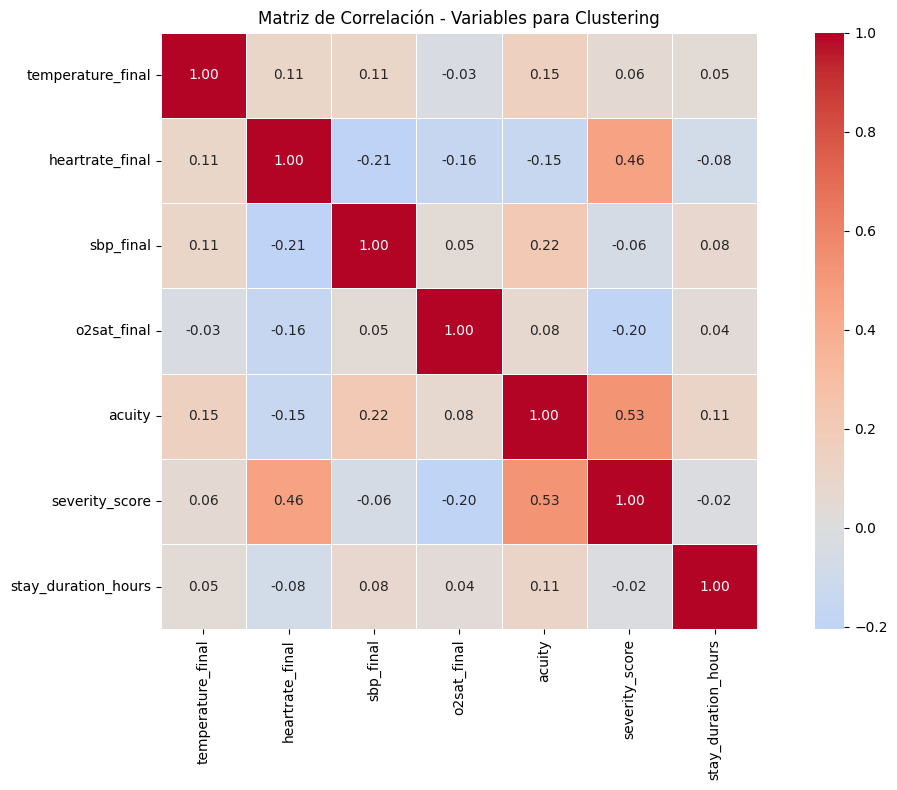

In [12]:
print("MATRIZ DE CORRELACIÓN")

# Variables numéricas potenciales para clustering
potential_vars = [
    'temperature_final', 'heartrate_final', 'sbp_final', 'dbp_final',
    'o2sat_final', 'pain_clean', 'acuity', 'severity_score',
    'stay_duration_hours', 'age'
]

potential_vars = [var for var in potential_vars if var in df_features.columns]
df_corr = df_features[potential_vars].copy()

# Matriz de correlación
correlation_matrix = df_corr.corr()
print("\nMatriz de correlación:")
print(correlation_matrix.round(2))

# Hatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación - Variables para Clustering')
plt.tight_layout()
plt.show()

In [27]:
# Selección de variables para clustering
clustering_vars = [
    'temperature_final',
    'heartrate_final',
    'sbp_final',
    'o2sat_final',
    'acuity',
    'severity_score',
    'stay_duration_hours'
]

df_cluster = df_features[clustering_vars].copy()
print(f"Datos iniciales para clustering: {df_cluster.shape}")

# Eliminamos filas con nulos
df_cluster_clean = df_cluster.dropna()
print(f"Datos después de eliminar nulos: {df_cluster_clean.shape}")

# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_clean)

print("Datos escalados correctamente")
print(f"Dimensiones datos escalados: {X_scaled.shape}")
print(f"Media después de escalado: {X_scaled.mean(axis=0).round(2)}")
print(f"Desviación estándar después de escalado: {X_scaled.std(axis=0).round(2)}")

Datos iniciales para clustering: (222, 7)
Datos después de eliminar nulos: (203, 7)
Datos escalados correctamente
Dimensiones datos escalados: (203, 7)
Media después de escalado: [ 0. -0. -0. -0. -0.  0.  0.]
Desviación estándar después de escalado: [1. 1. 1. 1. 1. 1. 1.]


K-MEANS


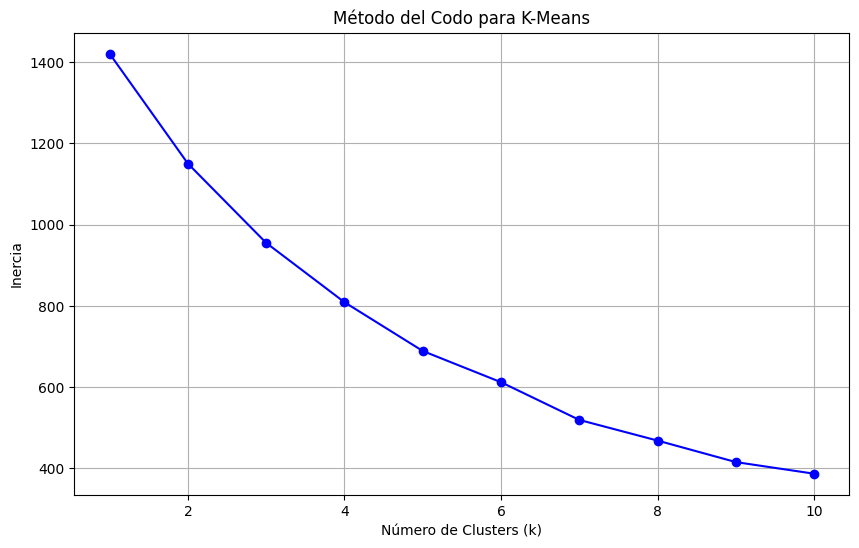

Gráfico K-MEANS
Inercias: ['k=1: 1421.00', 'k=2: 1150.46', 'k=3: 955.29', 'k=4: 809.21', 'k=5: 689.16', 'k=6: 612.24', 'k=7: 519.42', 'k=8: 468.55', 'k=9: 415.63', 'k=10: 387.00']


In [28]:
print("K-MEANS")

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.grid(True)
plt.show()

print("Gráfico K-MEANS")
print("Inercias:", [f"k={k}: {inertia:.2f}" for k, inertia in zip(k_range, inertia)])

In [29]:
print("APLICACIÓN DE K-MEANS")

# Selecciona k donde la curva se "dobla"
k_optimal = 3

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

df_cluster_clean['cluster_kmeans'] = kmeans_labels

print(f"K-Means aplicado con k={k_optimal}")
print("Distribución de clusters:")
print(df_cluster_clean['cluster_kmeans'].value_counts().sort_index())

# Estadísticas por cluster
print("\nCaracterísticas promedio por cluster:")
cluster_stats = df_cluster_clean.groupby('cluster_kmeans')[clustering_vars].mean()
print(cluster_stats.round(2))

APLICACIÓN DE K-MEANS
K-Means aplicado con k=3
Distribución de clusters:
cluster_kmeans
0    106
1     92
2      5
Name: count, dtype: int64

Características promedio por cluster:
                temperature_final  heartrate_final  sbp_final  o2sat_final  \
cluster_kmeans                                                               
0                           98.22            87.94     128.03        97.90   
1                           98.20            85.55     133.77        97.78   
2                           41.13            78.87     113.27        98.38   

                acuity  severity_score  stay_duration_hours  
cluster_kmeans                                               
0                 1.88            0.26                 8.13  
1                 3.00            1.27                 8.98  
2                 1.80            0.60                 5.87  


In [16]:
print("APLICACIÓN DE DBSCAN")

# DBSCAN con distintos parámetros
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

df_cluster_clean['cluster_dbscan'] = dbscan_labels

print("Resultados DBSCAN:")
print(f"Número de clusters encontrados: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Puntos considerados ruido: {(dbscan_labels == -1).sum()}")
print("Distribución de clusters DBSCAN:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

# Comparar con K-Means
print(f"\nCOMPARACIÓN K-MEANS vs DBSCAN")
print(f"K-Means clusters: {k_optimal}")
print(f"DBSCAN clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Puntos en clusters K-Means: {len(kmeans_labels)}")
print(f"Puntos en clusters DBSCAN: {len(dbscan_labels) - (dbscan_labels == -1).sum()}")

APLICACIÓN DE DBSCAN
Resultados DBSCAN:
Número de clusters encontrados: 6
Puntos considerados ruido: 99
Distribución de clusters DBSCAN:
-1    99
 0    43
 1    32
 2    10
 3     7
 4     8
 5     4
Name: count, dtype: int64

COMPARACIÓN K-MEANS vs DBSCAN
K-Means clusters: 3
DBSCAN clusters: 6
Puntos en clusters K-Means: 203
Puntos en clusters DBSCAN: 104


**Resultados obtenidos:**

- La matriz de correlación muestra relaciones moderadas esperadas, como entre heartrate y severity_score (0.46) y acuity y severity_score (0.53).
- K-Means ha identificado 3 clusters bien definidos:
  - Cluster 0 (106 pacientes, baja severidad),
  - Cluster 1 (92 pacientes, alta severidad con acuity 3.00),
  - Cluster 2 (5 pacientes, posiblemente erróneos con temperatura anómala de 41.1°F).
- DBSCAN ha identificado 6 clusters pero clasificando 99 puntos como ruido (48.8%), por lo que es un resultando menos útil
- K-Means parece que es más adecuado para estos datos, proporcionando clusters interpretables clínicamente.

###5.1) Visualización (PCA)

**Explicación:**

- Hemos hecho una reducción dimensional con PCA para visualizar los clusters en 2D, explicando el 46.1% de la varianza total (24.6% PC1 + 21.5% PC2). Para comparar la estructura de agrupamiento entre K-Means y DBSCAN.
- Después hemos hecho un análisis detallado de los clusters de K-Means integrando la información demográfica y clínica completa, examinando distribución por género, disposición final y scores de severidad para caracterizar cada grupo identificado.

VISUALIZACIÓN CON PCA
Varianza explicada por componentes PCA: [0.24570085 0.21536651]


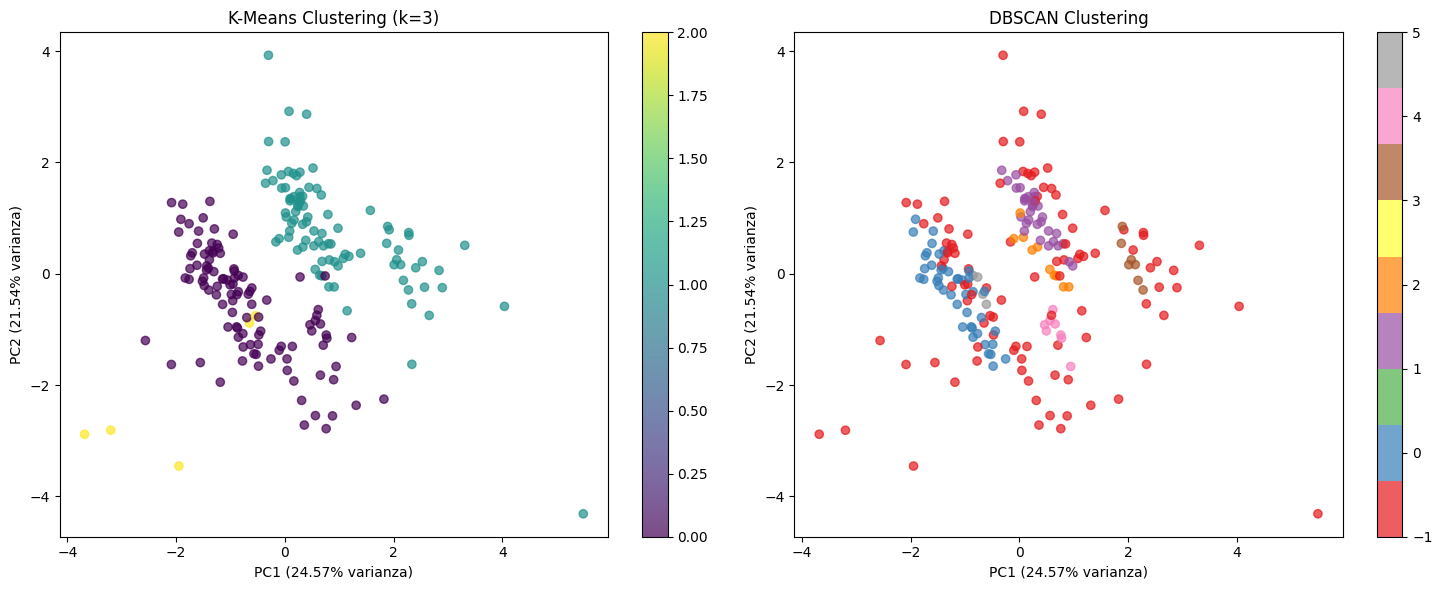

Gráficos PCA generados


In [30]:
print("VISUALIZACIÓN CON PCA")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Varianza explicada por componentes PCA: {pca.explained_variance_ratio_}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfica K-Means
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0].set_title(f'K-Means Clustering (k={k_optimal})')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.colorbar(scatter1, ax=axes[0])

# Gráfica DBSCAN
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='Set1', alpha=0.7)
axes[1].set_title('DBSCAN Clustering')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

print("Gráficos PCA generados")

In [31]:
print("ANÁLISIS DETALLADO CLUSTERS K-MEANS")

# Unión de los clusters con los datos originales
df_analysis = df_features.loc[df_cluster_clean.index].copy()
df_analysis['cluster_kmeans'] = kmeans_labels

# Análisis de características demográficas por cluster
print("\nDISTRIBUCIÓN POR GÉNERO:")
print(pd.crosstab(df_analysis['cluster_kmeans'], df_analysis['gender']))

print("\nDISTRIBUCIÓN POR DISPOSICIÓN:")
print(pd.crosstab(df_analysis['cluster_kmeans'], df_analysis['disposition']))

print("\nDISTRIBUCIÓN POR SCORE DE SEVERIDAD:")
print(pd.crosstab(df_analysis['cluster_kmeans'], df_analysis['severity_score']))

# Estadísticas clave por cluster
print("\nESTADÍSTICAS PROMEDIO POR CLUSTER:")
key_stats = ['temperature_final', 'heartrate_final', 'sbp_final', 'o2sat_final',
             'acuity', 'severity_score', 'stay_duration_hours']
cluster_summary = df_analysis.groupby('cluster_kmeans')[key_stats].mean()
print(cluster_summary.round(2))

ANÁLISIS DETALLADO CLUSTERS K-MEANS

DISTRIBUCIÓN POR GÉNERO:
gender           F   M
cluster_kmeans        
0               54  52
1               54  38
2                4   1

DISTRIBUCIÓN POR DISPOSICIÓN:
disposition     ADMITTED  ELOPED  HOME  LEFT AGAINST MEDICAL ADVICE  \
cluster_kmeans                                                        
0                     83       0    20                            0   
1                     48       1    37                            2   
2                      4       0     1                            0   

disposition     LEFT WITHOUT BEING SEEN  TRANSFER  
cluster_kmeans                                     
0                                     0         3  
1                                     2         2  
2                                     0         0  

DISTRIBUCIÓN POR SCORE DE SEVERIDAD:
severity_score   0   1   2  3
cluster_kmeans               
0               79  26   1  0
1                0  70  19  3
2                2

In [32]:
print("INTERPRETACIÓN DE CLUSTERS K-MEANS")

# Describir cada cluster basado en sus características
for cluster_id in sorted(df_analysis['cluster_kmeans'].unique()):
    cluster_data = df_analysis[df_analysis['cluster_kmeans'] == cluster_id]

    print(f"\n--- CLUSTER {cluster_id} ({len(cluster_data)} pacientes) ---")
    print(f"Temperatura promedio: {cluster_data['temperature_final'].mean():.1f}°F")
    print(f"Frecuencia cardíaca promedio: {cluster_data['heartrate_final'].mean():.1f} lpm")
    print(f"Presión arterial sistólica: {cluster_data['sbp_final'].mean():.1f} mmHg")
    print(f"Saturación de oxígeno: {cluster_data['o2sat_final'].mean():.1f}%")
    print(f"Acuity promedio: {cluster_data['acuity'].mean():.1f}")
    print(f"Score de severidad promedio: {cluster_data['severity_score'].mean():.1f}")
    print(f"Duración estancia: {cluster_data['stay_duration_hours'].mean():.1f} horas")

    # Características principales
    if cluster_data['severity_score'].mean() < 0.5:
        print("PERFIL: Pacientes de baja severidad")
    elif cluster_data['severity_score'].mean() > 1.0:
        print("PERFIL: Pacientes de alta severidad")
    else:
        print("PERFIL: Pacientes de severidad media")

print(f"\nCluster 2 tiene temperatura muy baja ({cluster_data['temperature_final'].mean():.1f}°F) - posible error en datos")

INTERPRETACIÓN DE CLUSTERS K-MEANS

--- CLUSTER 0 (106 pacientes) ---
Temperatura promedio: 98.2°F
Frecuencia cardíaca promedio: 87.9 lpm
Presión arterial sistólica: 128.0 mmHg
Saturación de oxígeno: 97.9%
Acuity promedio: 1.9
Score de severidad promedio: 0.3
Duración estancia: 8.1 horas
PERFIL: Pacientes de baja severidad

--- CLUSTER 1 (92 pacientes) ---
Temperatura promedio: 98.2°F
Frecuencia cardíaca promedio: 85.5 lpm
Presión arterial sistólica: 133.8 mmHg
Saturación de oxígeno: 97.8%
Acuity promedio: 3.0
Score de severidad promedio: 1.3
Duración estancia: 9.0 horas
PERFIL: Pacientes de alta severidad

--- CLUSTER 2 (5 pacientes) ---
Temperatura promedio: 41.1°F
Frecuencia cardíaca promedio: 78.9 lpm
Presión arterial sistólica: 113.3 mmHg
Saturación de oxígeno: 98.4%
Acuity promedio: 1.8
Score de severidad promedio: 0.6
Duración estancia: 5.9 horas
PERFIL: Pacientes de severidad media

Cluster 2 tiene temperatura muy baja (41.1°F) - posible error en datos


**Resultados obtenidos:**
- K-Means genera clusters más compactos y separables, mientras DBSCAN identifica múltiples grupos pequeños con muchos puntos como ruido.
- Hay tres perfiles claros: Cluster 0 (106 pacientes, 52.2%) con baja severidad (score 0.3), mayoría dados de alta a domicilio; Cluster 1 (92 pacientes, 45.3%) con alta severidad (score 1.3), acuity 3.0 y mayor tasa de admisión hospitalaria (52.2%); y Cluster 2 (5 pacientes, 2.5%) con temperaturas anómalamente bajas (41.1°F) lo cual pueden ser posibles errores de medición.
- La distribución por género es equilibrada en todos los clusters, y hay una clara correlación entre severidad y necesidad de admisión hospitalaria.

## 6) Análisis de asociación

**Explicación:**

- Preparamos los datos para el análisis de asociación seleccionando 10 variables categóricas relevantes que incluyen datos demográficos, clínicos y diagnósticos. Transformamos las variables numéricas binarias (fiebre, taquicardia, etc.) a formato categórico y agrupamos el score de severidad en tres categorías.
- Simplificamos las variables con muchas categorías (raza, códigos ICD) para que el análisis sea más manejable.
- Creamos transacciones donde cada paciente representa una transacción con múltiples items en formato "variable=valor".
- Aplicamos el algoritmo Apriori con un soporte mínimo del 5% para encontrar itemsets frecuentes y generamos reglas de asociación filtrando por lift > 1 y confianza > 40%.

In [40]:
print("PREPARACIÓN PARA ANÁLISIS DE ASOCIACIÓN")

available_vars = df_features.columns.tolist()
print("Variables disponibles en df_features:")
for var in available_vars:
    print(f"  {var}")

association_vars = [
    'gender',
    'race',
    'arrival_transport',
    'disposition',
    'fiebre',
    'taquicardia',
    'hipotension',
    'hipoxia',
    'severity_score',
    'icd_principal'
]

association_vars = [var for var in association_vars if var in df_features.columns]
print(f"\nVariables seleccionadas para asociación: {association_vars}")

# Creación del dataset para asociación
df_association = df_features[association_vars].copy()

# Convertimos variables numéricas a categóricas cuando haga falta
df_association['fiebre'] = df_association['fiebre'].map({0: 'No_Fiebre', 1: 'Fiebre'})
df_association['taquicardia'] = df_association['taquicardia'].map({0: 'No_Taquicardia', 1: 'Taquicardia'})
df_association['hipotension'] = df_association['hipotension'].map({0: 'No_Hipotension', 1: 'Hipotension'})
df_association['hipoxia'] = df_association['hipoxia'].map({0: 'No_Hipoxia', 1: 'Hipoxia'})

# Convertimos severity_score a categorías
df_association['severity_category'] = pd.cut(df_association['severity_score'],
                                           bins=[-1, 0, 1, 5],
                                           labels=['Baja_Severidad', 'Media_Severidad', 'Alta_Severidad'])

# Limpiamos ICD principal (cogindo solo primeros 3 caracteres para generalizar)
df_association['icd_group'] = df_association['icd_principal'].str[:3]

# Simplificamos race (agrupamos categorías poco frecuentes)
race_counts = df_association['race'].value_counts()
other_races = race_counts[race_counts < 10].index
df_association['race_simplified'] = df_association['race'].replace(other_races, 'OTHER')

print(f"\nDataset para asociación: {df_association.shape}")
print("\nVariables preparadas:")
for col in df_association.columns:
    print(f"  {col}: {df_association[col].nunique()} categorías")
    if df_association[col].nunique() < 10:
        print(f"    Valores: {df_association[col].unique()}")

PREPARACIÓN PARA ANÁLISIS DE ASOCIACIÓN
Variables disponibles en df_features:
  subject_id
  hadm_id
  stay_id
  intime
  outtime
  gender
  race
  arrival_transport
  disposition
  temperature_triage
  heartrate_triage
  resprate_triage
  o2sat_triage
  sbp_triage
  dbp_triage
  pain_triage
  acuity
  chiefcomplaint
  temperature_vitals
  heartrate_vitals
  resprate_vitals
  o2sat_vitals
  sbp_vitals
  dbp_vitals
  pain_vitals
  icd_codes
  num_diagnoses
  temperature_final
  heartrate_final
  sbp_final
  o2sat_final
  fiebre
  taquicardia
  hipotension
  hipoxia
  icd_principal
  stay_duration_hours
  arrival_hour
  severity_score

Variables seleccionadas para asociación: ['gender', 'race', 'arrival_transport', 'disposition', 'fiebre', 'taquicardia', 'hipotension', 'hipoxia', 'severity_score', 'icd_principal']

Dataset para asociación: (222, 13)

Variables preparadas:
  gender: 2 categorías
    Valores: ['F' 'M']
  race: 12 categorías
  arrival_transport: 4 categorías
    Valores: ['

In [41]:
print("CREACIÓN DE TRANSACCIONES")

# Eliminación de filas con valores nulos
df_association_clean = df_association.dropna()
print(f"Transacciones después de limpiar nulos: {len(df_association_clean)}")

# Creación de transacciones (cada fila es una transacción)
transactions = []
for idx, row in df_association_clean.iterrows():
    transaction = []
    for col in df_association_clean.columns:
        if pd.notna(row[col]):
            # Formato "Variable=Valor"
            item = f"{col}={row[col]}"
            transaction.append(item)
    transactions.append(transaction)

print(f"Número total de transacciones: {len(transactions)}")
print(f"Ejemplo de transacción 0: {transactions[0][:5]}...")  # 5 items
print(f"Número promedio de items por transacción: {np.mean([len(t) for t in transactions]):.1f}")

CREACIÓN DE TRANSACCIONES
Transacciones después de limpiar nulos: 222
Número total de transacciones: 222
Ejemplo de transacción 0: ['gender=F', 'race=WHITE - OTHER EUROPEAN', 'arrival_transport=WALK IN', 'disposition=ADMITTED', 'fiebre=No_Fiebre']...
Número promedio de items por transacción: 13.0


In [42]:
print("APLICACIÓN DEL ALGORITMO APRIORI")

# Transacciones a formato one-hot
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Formato one-hot: {df_encoded.shape}")
print(f"Número de items únicos: {len(te.columns_)}")
print(f"\nAlgunos items únicos: {list(te.columns_)[:10]}")

# Itemsets frecuentes
frequent_itemsets = apriori(df_encoded,
                           min_support=0.05,
                           use_colnames=True,
                           max_len=3)

print(f"\nItemsets frecuentes encontrados: {len(frequent_itemsets)}")
print("\nTop 10 itemsets más frecuentes:")
frequent_itemsets_sorted = frequent_itemsets.sort_values('support', ascending=False)
print(frequent_itemsets_sorted.head(10))

APLICACIÓN DEL ALGORITMO APRIORI
Formato one-hot: (222, 272)
Número de items únicos: 272

Algunos items únicos: ['arrival_transport=AMBULANCE', 'arrival_transport=OTHER', 'arrival_transport=UNKNOWN', 'arrival_transport=WALK IN', 'disposition=ADMITTED', 'disposition=ELOPED', 'disposition=HOME', 'disposition=LEFT AGAINST MEDICAL ADVICE', 'disposition=LEFT WITHOUT BEING SEEN', 'disposition=OTHER']

Itemsets frecuentes encontrados: 979

Top 10 itemsets más frecuentes:
      support                                           itemsets
9    0.986486                               (hipoxia=No_Hipoxia)
8    0.977477                       (hipotension=No_Hipotension)
5    0.977477                                 (fiebre=No_Fiebre)
143  0.968468   (hipotension=No_Hipotension, hipoxia=No_Hipoxia)
101  0.963964             (fiebre=No_Fiebre, hipoxia=No_Hipoxia)
100  0.954955     (fiebre=No_Fiebre, hipotension=No_Hipotension)
632  0.945946  (fiebre=No_Fiebre, hipotension=No_Hipotension,...
25   0.8018

In [43]:
print("REGLAS DE ASOCIACIÓN")

# Generar reglas
rules = association_rules(frequent_itemsets,
                         metric="confidence",
                         min_threshold=0.3)  # Confianza mínima del 30%

print(f"Reglas generadas: {len(rules)}")
print("\nEstructura de las reglas:")
print(rules.columns.tolist())

significant_rules = rules[
    (rules['lift'] > 1.0) &
    (rules['confidence'] > 0.4) &
    (rules['support'] > 0.05)
].sort_values('lift', ascending=False)

print(f"\nReglas significativas (lift > 1, confianza > 0.4): {len(significant_rules)}")

if len(significant_rules) > 0:
    print("\nTop 10 reglas más relevantes por lift:")
    display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    print(significant_rules[display_cols].head(10))
else:
    print("No se encontraron reglas con los criterios actuales. Relajando criterios...")
    display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    print(rules[display_cols].sort_values('lift', ascending=False).head(10))

REGLAS DE ASOCIACIÓN
Reglas generadas: 3484

Estructura de las reglas:
['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'representativity', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'certainty', 'kulczynski']

Reglas significativas (lift > 1, confianza > 0.4): 2004

Top 10 reglas más relevantes por lift:
                                      antecedents  \
2838  (hipotension=No_Hipotension, icd_group=401)   
2839                         (icd_principal=4019)   
2840                              (icd_group=401)   
2132            (fiebre=No_Fiebre, icd_group=401)   
2130       (icd_principal=4019, fiebre=No_Fiebre)   
2133                         (icd_principal=4019)   
2134                              (icd_group=401)   
2139            (icd_group=I10, fiebre=No_Fiebre)   
3037          (icd_group=401, hipoxia=No_Hipoxia)   
3038                         (icd_principal=4019)   

                                       

In [44]:
print("INTERPRETACIÓN DE REGLAS MÁS RELEVANTES")

if len(significant_rules) > 0:
    print("REGLAS MÁS SIGNIFICATIVAS:")
    print("=" * 80)

    for i, (idx, rule) in enumerate(significant_rules.head(10).iterrows()):
        print(f"\nREGLA {i+1}:")
        print(f"SI {set(rule['antecedents'])} → ENTONCES {set(rule['consequents'])}")
        print(f"Soporte: {rule['support']:.3f} ({rule['support']*100:.1f}% de las transacciones)")
        print(f"Confianza: {rule['confidence']:.3f} ({rule['confidence']*100:.1f}% de los casos con antecedente tienen consecuente)")
        print(f"Lift: {rule['lift']:.3f} ({(rule['lift']-1)*100:.1f}% más probable que al azar)")
        print("-" * 50)

else:
    best_rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False]).head(10)
    print("MEJORES REGLAS DISPONIBLES:")
    print("=" * 80)

    for i, (idx, rule) in enumerate(best_rules.iterrows()):
        print(f"\nREGLA {i+1}:")
        print(f"SI {set(rule['antecedents'])} → ENTONCES {set(rule['consequents'])}")
        print(f"Soporte: {rule['support']:.3f} | Confianza: {rule['confidence']:.3f} | Lift: {rule['lift']:.3f}")
        print("-" * 50)

INTERPRETACIÓN DE REGLAS MÁS RELEVANTES
REGLAS MÁS SIGNIFICATIVAS:

REGLA 1:
SI {'hipotension=No_Hipotension', 'icd_group=401'} → ENTONCES {'icd_principal=4019'}
Soporte: 0.059 (5.9% de las transacciones)
Confianza: 1.000 (100.0% de los casos con antecedente tienen consecuente)
Lift: 17.077 (1607.7% más probable que al azar)
--------------------------------------------------

REGLA 2:
SI {'icd_principal=4019'} → ENTONCES {'hipotension=No_Hipotension', 'icd_group=401'}
Soporte: 0.059 (5.9% de las transacciones)
Confianza: 1.000 (100.0% de los casos con antecedente tienen consecuente)
Lift: 17.077 (1607.7% más probable que al azar)
--------------------------------------------------

REGLA 3:
SI {'icd_group=401'} → ENTONCES {'icd_principal=4019', 'hipotension=No_Hipotension'}
Soporte: 0.059 (5.9% de las transacciones)
Confianza: 1.000 (100.0% de los casos con antecedente tienen consecuente)
Lift: 17.077 (1607.7% más probable que al azar)
--------------------------------------------------


In [45]:
print("ANÁLISIS DE PATRONES ESPECÍFICOS")

severity_rules = rules[
    rules['antecedents'].astype(str).str.contains('severity', case=False) |
    rules['consequents'].astype(str).str.contains('severity', case=False)
]

if len(severity_rules) > 0:
    print("\nREGLAS RELACIONADAS CON SEVERIDAD:")
    display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    print(severity_rules[display_cols].sort_values('lift', ascending=False).head(5))

diagnosis_rules = rules[
    rules['antecedents'].astype(str).str.contains('icd', case=False) |
    rules['consequents'].astype(str).str.contains('icd', case=False)
]

if len(diagnosis_rules) > 0:
    print("\nREGLAS RELACIONADAS CON DIAGNÓSTICOS:")
    display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    print(diagnosis_rules[display_cols].sort_values('lift', ascending=False).head(5))

gender_rules = rules[
    rules['antecedents'].astype(str).str.contains('gender', case=False) |
    rules['consequents'].astype(str).str.contains('gender', case=False)
]

if len(gender_rules) > 0:
    print("\nREGLAS RELACIONADAS CON GÉNERO:")
    display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    print(gender_rules[display_cols].sort_values('lift', ascending=False).head(5))

print(f"\nResumen final:")
print(f"Total transacciones analizadas: {len(transactions)}")
print(f"Itemsets frecuentes encontrados: {len(frequent_itemsets)}")
print(f"Reglas generadas: {len(rules)}")
print(f"Reglas significativas: {len(significant_rules)}")

ANÁLISIS DE PATRONES ESPECÍFICOS

REGLAS RELACIONADAS CON SEVERIDAD:
                                            antecedents  \
2272  (fiebre=No_Fiebre, severity_category=Alta_Seve...   
2276                                 (severity_score=2)   
3177  (hipoxia=No_Hipoxia, severity_category=Alta_Se...   
2978  (hipotension=No_Hipotension, severity_category...   
2982                                 (severity_score=2)   

                                            consequents   support  confidence  \
2272                                 (severity_score=2)  0.076577    0.944444   
2276  (fiebre=No_Fiebre, severity_category=Alta_Seve...  0.076577    0.850000   
3177                                 (severity_score=2)  0.090090    0.909091   
2978                                 (severity_score=2)  0.090090    0.909091   
2982  (hipotension=No_Hipotension, severity_category...  0.090090    1.000000   

           lift  
2272  10.483333  
2276  10.483333  
3177  10.090909  
2978  10.090909  

VISUALIZACIÓN DE REGLAS


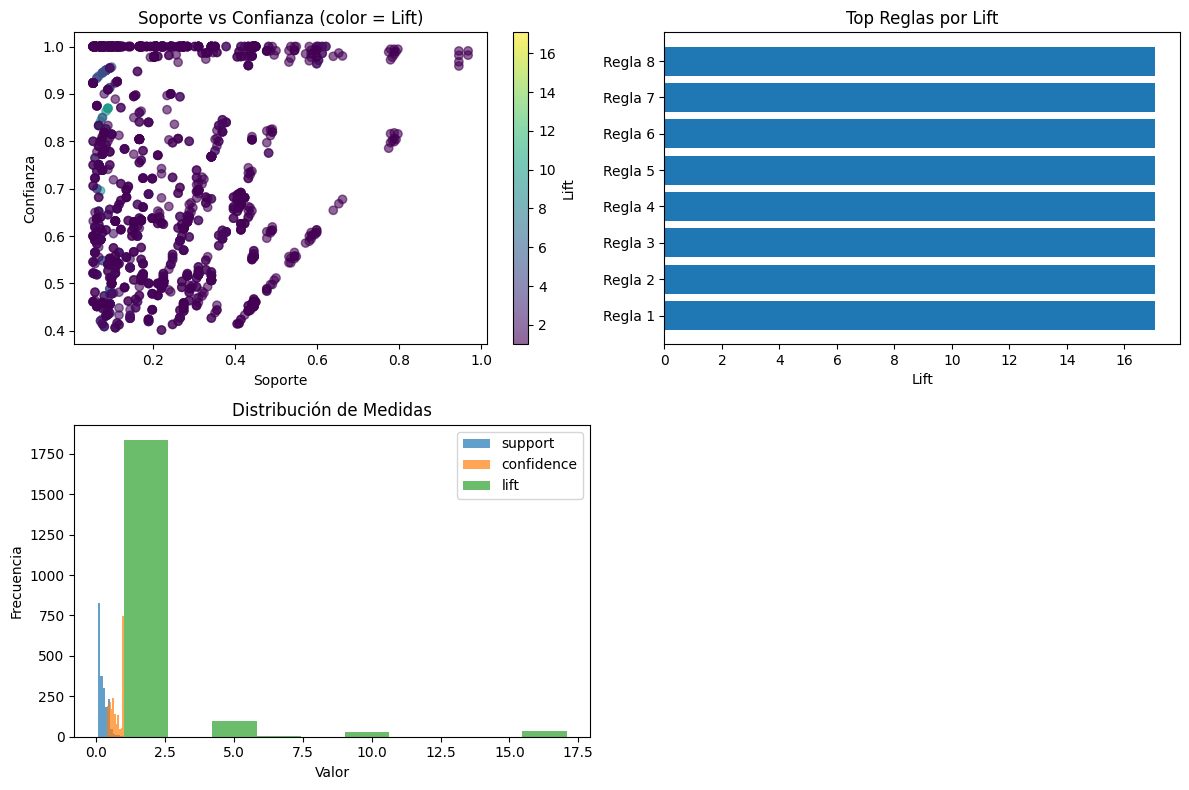

Gráficos de reglas generados


In [46]:
print("VISUALIZACIÓN DE REGLAS")

if len(significant_rules) > 0:
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(significant_rules['support'], significant_rules['confidence'],
                alpha=0.6, c=significant_rules['lift'], cmap='viridis')
    plt.xlabel('Soporte')
    plt.ylabel('Confianza')
    plt.title('Soporte vs Confianza (color = Lift)')
    plt.colorbar(label='Lift')

    plt.subplot(2, 2, 2)
    top_rules = significant_rules.head(8)
    y_pos = range(len(top_rules))
    plt.barh(y_pos, top_rules['lift'])
    plt.yticks(y_pos, [f"Regla {i+1}" for i in y_pos])
    plt.xlabel('Lift')
    plt.title('Top Reglas por Lift')

    plt.subplot(2, 2, 3)
    measures = ['support', 'confidence', 'lift']
    for measure in measures:
        plt.hist(significant_rules[measure], alpha=0.7, label=measure, bins=10)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Medidas')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Gráficos de reglas generados")
else:
    print("No hay suficientes reglas significativas para visualizar")

**Resultados obtenidos:**

- El análisis ha generado 979 itemsets frecuentes y 3,484 reglas de asociación, de las cuales 2,004 son significativas.
- Las reglas más fuertes (lift 17.08) involucran diagnósticos de hipertensión (ICD 401/4019 e I10), mostrando que estos pacientes consistentemente no presentan hipotensión, fiebre ni hipoxia (100% confianza).
- Vemos patrones importantes como la asociación entre severidad alta y ausencia de fiebre (lift 10.48), y relaciones demográficas como la asociación entre hombres con taquicardia y alta severidad (lift 5.79).
- Las reglas con diagnósticos tienen soporte del 5.9%, indicando que estos patrones afectan a aproximadamente 13 pacientes.

##7) Conclusiones

- Hemos obtenido insights valiosos sobre los patrones clínicos de los pacientes en urgencias. Con el clustering se han podido identificar tres perfiles claros de pacientes: un grupo mayoritario de baja severidad (44.6%), un grupo de alta severidad (45.3%) que requiere más admisiones hospitalarias, y un grupo pequeño con datos posiblemente erróneos.

- Las reglas de asociación han mostrado patrones clínicos consistentes, destacando que los pacientes hipertensos rara vez presentan complicaciones agudas como hipotensión, fiebre o hipoxia. También hemos observado que la severidad alta no necesariamente se asocia con fiebre, lo que sugiere que hay otros factores que contribuyen más a la gravedad del paciente.

- Desde el punto de vista metodológico, confirmamos que K-Means es más efectivo que DBSCAN para este tipo de datos clínicos, y que la ingeniería de características con variables clínicamente relevantes (como nuestro score de severidad compuesto) enriquece significativamente el análisis.